# Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt

from sklearn import metrics as skmetrics
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from bayes_opt import BayesianOptimization

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

In [3]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

# Evaluation Metrics Function

In [4]:
def print_statistics(y_actual, y_pred, y_prob, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision: {round(skmetrics.precision_score(y_actual, y_pred),5)}")
  print(f"recall: {round(skmetrics.recall_score(y_actual, y_pred),5)}")
  print(f"f1 score: {round(skmetrics.f1_score(y_actual, y_pred),5)}")
  prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob)
  print(f"pr auc score: {round(skmetrics.auc(recall, prec),5)}")

# Fitting XGBoost model

In [5]:
xgb_model = xgb.XGBClassifier().fit(X_smote, y_smote)

In [6]:
train_pred_xgb = xgb_model.predict(X_smote)
train_pred_xgb_prob = xgb_model.predict_proba(X_smote)[:,1]
val_pred_xgb = xgb_model.predict(X_val)
val_pred_xgb_prob = xgb_model.predict_proba(X_val)[:,1]
test_pred_xgb = xgb_model.predict(X_test)
test_pred_prob = xgb_model.predict_proba(X_test)[:,1]
print_statistics(y_smote, train_pred_xgb, train_pred_xgb_prob, 'train')
print_statistics(y_val, val_pred_xgb, val_pred_xgb_prob, 'val')
print_statistics(y_test, test_pred_xgb, test_pred_prob, 'test')

=====================train====================
accuracy: 0.97194
precision: 0.98556
recall: 0.95791
f1 score: 0.97154
pr auc score: 0.99744
=====================val====================
accuracy: 0.92121
precision: 0.89755
recall: 0.79949
f1 score: 0.84568
pr auc score: 0.85176
=====================test====================
accuracy: 0.9167
precision: 0.91512
recall: 0.76221
f1 score: 0.8317
pr auc score: 0.85663


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

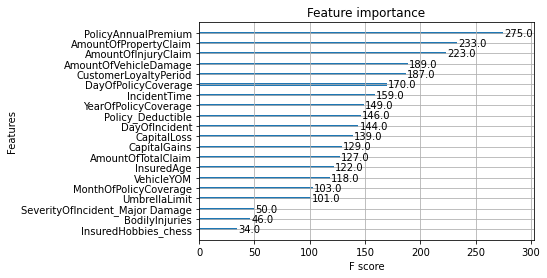

In [7]:
# Top 20 Most Important Features in XGB
xgb.plot_importance(xgb_model, max_num_features=20)

# Choosing the top 86 features

In [23]:
thresholds = sort(xgb_model.feature_importances_)
thres = thresholds[-86]

selection = SelectFromModel(xgb_model, threshold=thres, prefit=True)
select_X_train = selection.transform(X_smote.to_numpy())

# train model
selection_model = xgb.XGBClassifier()
selection_model.fit(select_X_train, y_smote)

# eval model
select_X_val = selection.transform(X_val.to_numpy())
y_pred = selection_model.predict_proba(select_X_val)[:,1]
predictions = [round(value) for value in y_pred]
print_statistics(y_val, predictions, y_pred, 'Val: Threshold={}, n={}'.format(thres, select_X_train.shape[1]))

=====================Val: Threshold=0.002319813473150134, n=86====================
accuracy: 0.90767
precision: 0.86782
recall: 0.77635
f1 score: 0.81954
pr auc score: 0.81796


In [22]:
# Getting selected features for x test
select_X_test = selection.transform(X_test.to_numpy())
y_pred = selection_model.predict_proba(select_X_test)[:,1]
predictions = [round(value) for value in y_pred]
print_statistics(y_test, predictions, y_pred, 'Test: Threshold={}, n={}'.format(thres, select_X_train.shape[1]))

=====================Test: Threshold=0.002319813473150134, n=86====================
accuracy: 0.89587
precision: 0.85994
recall: 0.73393
f1 score: 0.79196
pr auc score: 0.83992


# Hyperparameter Tuning using Bayesian Optimization

In [15]:
seed = 1

def xgbc_func(max_depth,learning_rate,n_estimators,reg_alpha):
    
    estimator_function = xgb.XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = seed)
    # Fit the estimator
    estimator_function.fit(select_X_train, y_smote)
    probs = estimator_function.predict_proba(select_X_val)
    probs = probs[:,1]
    pred = estimator_function.predict(select_X_val)
    prec, recall, thresholds = skmetrics.precision_recall_curve(y_val, probs)
    val_prauc = skmetrics.auc(recall, prec)
    val_acc = skmetrics.accuracy_score(y_val, pred)
    val_prec = skmetrics.precision_score(y_val, pred)
    val_recall = skmetrics.recall_score(y_val, pred)
    val_f1 = skmetrics.f1_score(y_val, pred)
    
    return np.array([val_acc, val_prauc, val_prec, val_recall, val_f1]).mean()

In [16]:
gp_params = {"alpha": 1e-10}

hyperparameter_space = {
    'max_depth': (1, 100),
    'learning_rate': (0, 1),
    'n_estimators' : (10,500),
    'reg_alpha': (0,1),
}

xgbcBO = BayesianOptimization(f = xgbc_func, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

In [17]:
xgbcBO.maximize(init_points=3, n_iter=20, **gp_params)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------
| 1         | 0.825     | 0.417     | 72.31     | 10.06     | 0.3023    |
| 2         | 0.8443    | 0.1468    | 10.14     | 101.3     | 0.3456    |
| 3         | 0.8342    | 0.3968    | 54.34     | 215.4     | 0.6852    |
| 4         | 0.8267    | 0.5747    | 11.05     | 100.8     | 0.5849    |
| 5         | 0.8362    | 0.4426    | 41.93     | 278.4     | 0.7442    |
| 6         | 0.8349    | 0.6234    | 23.1      | 480.0     | 0.8047    |
| 7         | 0.8436    | 0.02121   | 80.98     | 482.8     | 0.7021    |
| 8         | 0.7797    | 0.3644    | 3.217     | 84.68     | 0.9715    |
| 9         | 0.8406    | 0.3546    | 41.78     | 277.8     | 0.832     |
| 10        | 0.8217    | 0.0857    | 8.914     | 103.2     | 0.4904    |
| 11        | 0.8293    | 0.8011    | 82.02     | 481.4     | 0.5701    |


/Users/junwei/opt/anaconda3/envs/btproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 12        | 0.273     | 0.0       | 79.75     | 484.1     | 0.8313    |
| 13        | 0.8394    | 0.2362    | 82.44     | 482.7     | 0.5974    |
| 14        | 0.8408    | 0.3305    | 8.306     | 101.0     | 0.7172    |
| 15        | 0.7931    | 0.004104  | 43.76     | 277.5     | 0.4851    |
| 16        | 0.8378    | 0.7465    | 40.06     | 278.4     | 0.9998    |
| 17        | 0.8272    | 0.7946    | 9.511     | 98.9      | 0.6865    |
| 18        | 0.8448    | 0.02538   | 80.63     | 481.1     | 0.4827    |
| 19        | 0.8175    | 1.0       | 10.79     | 102.8     | 1.0       |
| 20        | 0.8346    | 0.2709    | 40.37     | 275.8     | 0.1786    |
| 21        | 0.8432    | 0.372     | 38.68     | 277.2     | 0.317     |
| 22        | 0.8425    | 0.3426    | 38.38     | 274.5     | 0.2637    |
| 23        | 0.8318    | 0.4291    | 36.23     | 274.9     | 0.2027    |


In [18]:
# Best Hyperparameters selected
xgbcBO.max

{'target': 0.8447524910500629,
 'params': {'learning_rate': 0.02537845994490573,
  'max_depth': 80.62836215803664,
  'n_estimators': 481.0626480725457,
  'reg_alpha': 0.4827111023976818}}

In [19]:
xgb_tuned_model = xgb.XGBClassifier(max_depth=int(xgbcBO.max['params']['max_depth']),
                                           n_estimators= int(xgbcBO.max['params']['n_estimators']),
                                           reg_alpha = xgbcBO.max['params']['reg_alpha'],
                                           learning_rate = xgbcBO.max['params']['learning_rate'],
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = 1,
                                           booster='gbtree')

xgb_tuned_model.fit(select_X_train, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02537845994490573,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=80, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=481,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto', ...)

In [20]:
train_pred_xgb_tuned = xgb_tuned_model.predict(select_X_train)
train_pred_xgb_tuned_prob = xgb_tuned_model.predict_proba(select_X_train)[:,1]
val_pred_xgb_tuned = xgb_tuned_model.predict(select_X_val)
val_pred_xgb_tuned_prob = xgb_tuned_model.predict_proba(select_X_val)[:,1]
test_pred_xgb_tuned = xgb_tuned_model.predict(select_X_test)
test_pred_tuned_prob = xgb_tuned_model.predict_proba(select_X_test)[:,1]
print_statistics(y_smote, train_pred_xgb_tuned, train_pred_xgb_tuned_prob, 'train')
print_statistics(y_val, val_pred_xgb_tuned, val_pred_xgb_tuned_prob, 'val')
print_statistics(y_test, test_pred_xgb_tuned, test_pred_tuned_prob, 'test')

=====================train====================
accuracy: 0.99753
precision: 0.99857
recall: 0.99649
f1 score: 0.99753
pr auc score: 0.99996
=====================val====================
accuracy: 0.91045
precision: 0.87143
recall: 0.78406
f1 score: 0.82544
pr auc score: 0.83238
=====================test====================
accuracy: 0.90281
precision: 0.875
recall: 0.74679
f1 score: 0.80583
pr auc score: 0.84587
